# Apple Software Engineer Job Openings Analysis
Analytical objects: all jobs related to the keyword `software`.

[Web scraper notebook](https://github.com/a19990506/Hello-World/blob/master/project/Apple_webCrawler.ipynb)

In [1]:
# Make your plot output stored in the notebook.
%matplotlib inline

import sys
sys.path.insert(0, '../modules/')
from fintextmin import *

import nltk
import pandas
import matplotlib
import numpy as np
from collections import OrderedDict
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

df = pandas.read_csv('data/apple_jobs.csv',encoding='iso-8859-1')
df.head(10)

,title,location,minimum_qual,preferred_qual,responsibilities,education&experience
0,Software Technician,"Santa Clara Valley (Cupertino), California, Un...",2-5 years experience supporting or deploying a...,NaN,"As a software techician, you will assist with ...","AS/BS in Information Technology, or equivalent"
1,Software Engineer,"Santa Clara Valley (Cupertino), California, Un...",KEY QUALIFICATIONS\nA genuine passion for fixi...,ADDITIONAL REQUIREMENTS\nReal hands-on experie...,DESCRIPTION\nWork with multi-functional teams ...,EDUCATION\nBS or MS in Computer Engineering or...
2,Software Engineer,"Santa Clara Valley (Cupertino), California, Un...",- 3+ years experience working on large scale d...,NaN,"This position will design, implement and debug...","BS, MS or PhD, in Computer Science, or equival..."
3,Software Engineer,"Santa Clara Valley (Cupertino), California, Un...",- 3+ years experience working on large scale d...,NaN,"This position will design, implement and debug...","BS, MS or PhD, in Computer Science, or equival..."
4,Software Engineer,"Santa Clara Valley (Cupertino), California, Un...",Demonstrated experience integrating full-syste...,NaN,"Extraordinary planning, critical thinking, and...","M.S. or PhD in Computer Science, Electrical En..."
5,Software Engineer,"Santa Clara Valley (Cupertino), California, Un...",A successful track-record and proven experienc...,NaN,"We are building, and supporting new, critical ...",BS or MS in Computer Science or equivalent wor...
6,Software Engineer,"Austin, Texas, United States",Passion to create amazing products which users...,NaN,JOB SUMMARY\nImagine what you could do here to...,A BS/MS/PhD in Electrical or Computer Engineer...
7,Software Engineer,"Hyderabad, Telangana, India",In-depth understanding of data structures and ...,NaN,Design and build data pipelines on MPP platfor...,Bachelorâs Degree or Equivalent with 2+ year...
8,Software Engineer,"Austin, Texas, United States",Passion to create amazing products which users...,NaN,JOB SUMMARY\nImagine what you could do here to...,A BS/MS/PhD in Electrical or Computer Engineer...
9,Software Engineer,"Santa Clara Valley (Cupertino), California, Un...",2-7 years experience developing system softwar...,Experience designing SW interfaces or APIs is ...,HID Software is looking for an engineer to wor...,BS/MS in CS/CE (or equivalent)


## 1. Degree Requirements

In [2]:
def tokenize(tokenizer: nltk.tokenize.MWETokenizer, s: str, lowercase=True, preserve_case_words=[]):
    """ Tokenize given string using nltk MWETokenizer.
    :param case: convert all tokens into lowercase.
    :param exclude_words: words that should preserve their cases.
    :return: a list of tokens.
    """
    tokens = nltk.tokenize.word_tokenize(s)
    tokens = tokenizer.tokenize(tokens)
    
    # Remove tokens that are either purely digits or purely punctuations.
    tokens = list(filter(lambda token: not token.isdigit() and re.search('[a-zA-Z]', token), tokens))

    # Since nltk MWETokenizer will not split tokens that contain a slash,
    # we'll have to do it ourselves.
    for token in tokens:
        if '/' in token:
            tokens += token.split('/')
            tokens.remove(token)
            
    # Lowercase conversion.
    tokens = [token.lower() if token not in preserve_case_words else token for token in tokens ]
            
    return tokens

In [3]:
def count_keywords_freq(df: pandas.DataFrame, col_name: str, keywords: list, none=False):
    """ Given a list of keywords and count their frequency in
    the specified pandas dataframe.
    :param d: target pandas dataframe.
    :param col_name: target column name.
    :param keywords: a list of keywords.
    :param none: count the items that contain no specified keywords at all.
    :return: keyword frequency dict.
    """
    freq = {keyword: 0 for keyword in keywords}
    
    for keyword in keywords:
        freq[keyword] = df[col_name].str.contains(keyword, regex=False).sum()
    
    if none is True:
        freq['None'] = 0
        for col in df[col_name]:
            freq['None'] += 0 if type(col) is str and any(w in col for w in keywords) else 1
                    
    return freq

In [4]:
keywords = ['PhD', 'Master', 'MBA', 'BA', 'BS', 'Bachelor']

# Count keyword frequency.
degree_reqs = count_keywords_freq(df, 'education&experience', keywords, none=True)

print("Education & Experience: " + str(degree_reqs))

Education & Experience: {'PhD': 258, 'Master': 259, 'MBA': 66, 'BA': 149, 'BS': 1091, 'Bachelor': 469, 'None': 401}


In [5]:
degree_df = pandas.DataFrame.from_dict(degree_reqs, orient='index', columns=['Count'])

degree_df

,Count
PhD,258
Master,259
MBA,66
BA,149
BS,1091
Bachelor,469
None,401


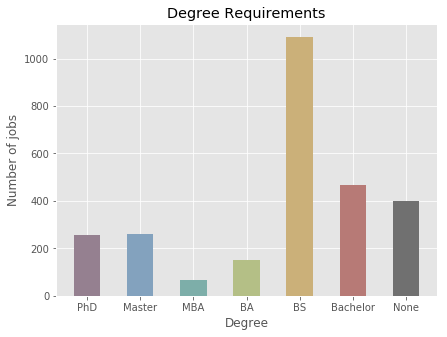

In [6]:
colors = ['#958090', '#83A2BE', '#7DAEA9', '#B4BF86', '#CBB079', '#B77A76', '#707070', '#AAAAAA']

degree_labels = list(degree_reqs.keys())
degree_values = list(degree_reqs.values())

plt.figure(figsize=(15, 5))

# In this plot, there will be 1 row, 2 columns.
plt.subplot(1, 2, 1) # Drawing the 1st subplot.
plt.bar(degree_labels, degree_values, color=colors, width=0.5)
plt.xlabel('Degree')
plt.ylabel('Number of jobs')
plt.title('Degree Requirements')

plt.savefig('out_graphs/apple_degree_requirements.png', format='png')
plt.show()

## 2. Experience Requirements

In [7]:
def extract_experience(df: pandas.DataFrame, col_name: str, start_year=0, end_year=25):
    """ Extract years of experiences required
    :param df: target dataframe.
    :param col_name: name of the column that contains strings
                     like `4 years of experience in ...`
    :param start_year: the starting year in the list returned.
    :param end_year: the last year in the list returned.
    :return: a list of years of exp required (index by years)
    """
    import re
    
    exp_list = [0] * 26
    
    for col in df[col_name]:
        if type(col) is not str:
            continue
        exp_required = re.findall('\d+ year', col)
        exp_required =exp_required+ re.findall('\d+\+ year', col)
        year = 0 if not exp_required else int(exp_required[0].replace(' year', '').replace('+', ''))
        exp_list[year] += 1
        
    return exp_list

In [8]:
min_exp_list = extract_experience(df, 'minimum_qual')

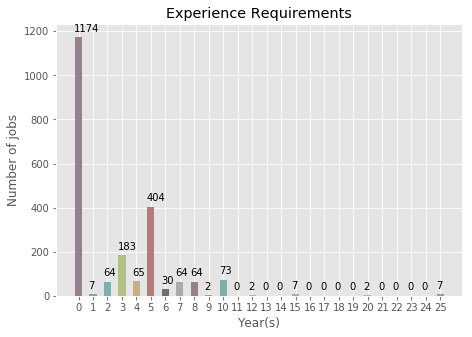

In [9]:
colors = ['#958090', '#83A2BE', '#7DAEA9', '#B4BF86', '#CBB079', '#B77A76', '#707070', '#AAAAAA']
labels = np.arange(len(min_exp_list))

plt.figure(figsize=(16, 5))

# In this plot, there will be 1 row, 2 columns.
plt.subplot(1, 2, 1) # Drawing the 1st subplot.
plt.bar(np.arange(26), min_exp_list[0:26], color=colors, width=0.5)
plt.xticks(labels[0:26])
plt.xlabel('Year(s)')
plt.ylabel('Number of jobs')
plt.title('Experience Requirements')
for i, v in enumerate(min_exp_list[0:26]):
    plt.text(i - 0.3, v+25, str(v), color='black')
    
plt.savefig('out_graphs/apple_exp_requirements.png', format='png')
plt.show()

## 3. Top 8 Job Titles

In [10]:
jobs_freq = {}

for col in df['title']:
    if type(col) is not str:
        continue
    col = col.split(',')[0]
    if col in jobs_freq:
        jobs_freq[col] += 1
    else:
        jobs_freq[col] = 1
        
jobs_freq = dict(sorted(jobs_freq.items(), key=lambda kv: kv[1], reverse=True))

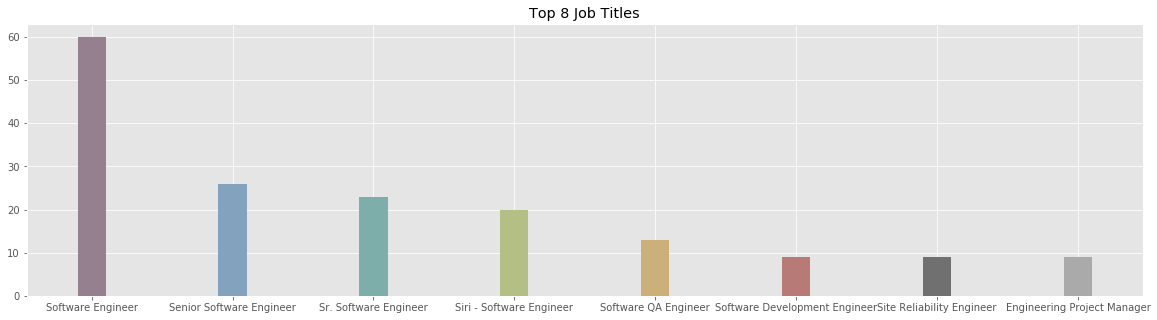

In [11]:
colors = ['#958090', '#83A2BE', '#7DAEA9', '#B4BF86', '#CBB079', '#B77A76', '#707070', '#AAAAAA']

min_labels = list(jobs_freq.keys())[0:8]
min_values = list(jobs_freq.values())[0:8]

plt.figure(figsize=(20, 5))
plt.bar(min_labels, min_values, color=colors, width=0.2)
plt.title('Top 8 Job Titles')

plt.savefig('out_graphs/apple_top_job_titles.png', format='png')
plt.show()

## 4. Top 10 Programming Languages

In [12]:
lang_colors = {
    'C++': '#F34B7D',
    'Java': '#B07219',
    'Python': '#3572A5',
    'JavaScript': '#F1E05A',
    'Go': '#375EAB',
    'PHP': '#4F5D95',
    'SQL': '#494D5C',
    'Ruby': '#701516',
    'Swift': '#FFAC45',
    'Kotlin': '#F18E33',
    'C#': '#178600',
    'Objective C': '#438EFF'
}

In [13]:
langs = lang_colors.keys()
tokenizer = nltk.tokenize.MWETokenizer(separator=' ')
# Count keyword frequency.
min_lang_reqs = count_keywords_freq(df, 'minimum_qual', langs)
pref_lang_reqs = count_keywords_freq(df, 'preferred_qual', langs)

# Sort the dicts.
min_lang_reqs = dict(sorted(min_lang_reqs.items(), key=lambda kv: kv[1], reverse=True))
pref_lang_reqs = dict(sorted(pref_lang_reqs.items(), key=lambda kv: kv[1], reverse=True))

# Create DataFrame from dict.
min_lang_df = pandas.DataFrame.from_dict(min_lang_reqs, orient='index', columns=['Count'])
pref_lang_df = pandas.DataFrame.from_dict(pref_lang_reqs, orient='index', columns=['Count'])

print(min_lang_reqs)
print(pref_lang_reqs)

{'C++': 626, 'Python': 623, 'Java': 586, 'SQL': 278, 'Go': 269, 'Swift': 193, 'Ruby': 132, 'JavaScript': 129, 'PHP': 33, 'Objective C': 31, 'C#': 15, 'Kotlin': 2}
{'Swift': 54, 'Python': 49, 'C++': 48, 'Java': 47, 'JavaScript': 21, 'SQL': 21, 'Go': 18, 'Objective C': 8, 'Ruby': 7, 'PHP': 4, 'Kotlin': 0, 'C#': 0}


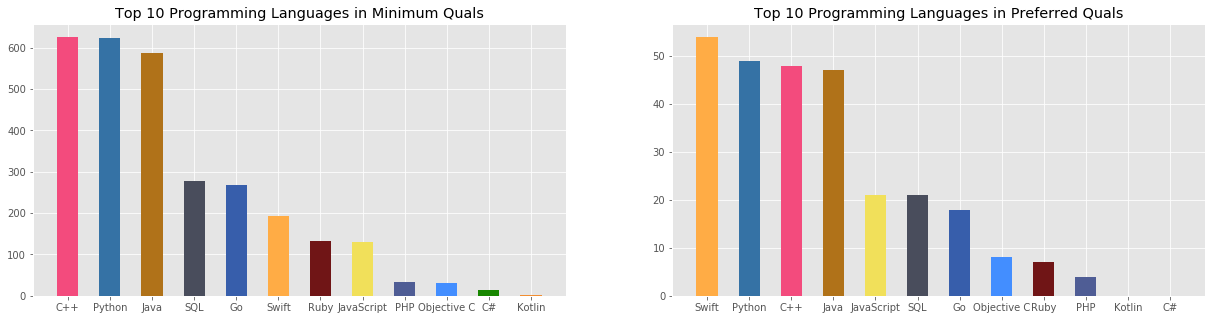

In [14]:
min_labels = list(min_lang_reqs.keys())
min_values = list(min_lang_reqs.values())
min_colors = [lang_colors[k] for k, v in min_lang_reqs.items()]

pref_labels = list(pref_lang_reqs.keys())
pref_values = list(pref_lang_reqs.values())
pref_colors = [lang_colors[k] for k, v in pref_lang_reqs.items()]


plt.figure(figsize=(21, 5))

plt.subplot(121)
plt.bar(min_labels, min_values, color=min_colors, width=0.5)
plt.title('Top 10 Programming Languages in Minimum Quals')

plt.subplot(122)
plt.bar(pref_labels, pref_values, color=pref_colors, width=0.5)
plt.title('Top 10 Programming Languages in Preferred Quals')

plt.savefig('out_graphs/apple_top_prog_langs.png', format='png')
plt.show()

## 5. Top Demanding Skills from Job Descriptions

Extract keywords and create word clouds from the following:
* Minimum Qualifications
* Preferred Qualifications
* Responsibilities

### Word frequency matrix

For each job, we create a wfm (word frequency matrix) and store all results in a dict.

In [15]:
def import_terms(tokenizer: nltk.tokenize.MWETokenizer, term_file_path: str):
    """ Import all user-defined untokenizable terms from a file into nltk MWETokenizer.
    :param tokenizer: nltk MWETokenizer instance.
    :param text_file_path: path to the file.
    """
    with open(term_file_path, 'r') as f:
        for line in f:
            tokenizer.add_mwe(line.strip().split())

In [16]:
def create_word_freq_dict(tokenizer, df, col_name, lowercase=True, preserve_case_words=[]):
    """ Create a word frequency dict
    :param tokenizer: nltk MWETokenizer.
    :param df: source pandas dataframe.
    :param col_name: name of the column to create wfm from.
    :param lowercase: convert all tokens into lowercase.
    :param preserve_case_words: words that should preserve their cases.
    :return: a word frequency dict (dict of dict, separated by job indices).
    """
    freq = {}
    
    for i, col in enumerate(df[col_name]):
        if type(col) is not str:
            continue
        freq[i] = {}
        
        words = tokenize(tokenizer, col, lowercase=True, preserve_case_words=preserve_case_words)
        for word in words:
            if word in freq:
                freq[i][word] += 1
            else:
                freq[i][word] = 1
                
    return freq

In [17]:
def create_wfm(word_frequency_dict: dict):
    """ Create word frequency matrix from the specified word frequency dict """
    dwf_list = [pandas.DataFrame(list(freq.values()), index=freq.keys()) for freq in word_frequency_dict.values()]
    wfm = pandas.concat(dwf_list, axis=1)
    wfm = np.transpose(wfm).fillna(0)
    wfm.index = word_frequency_dict.keys()
    return wfm

In [18]:
# Initialize nltk MWETokenizer.
tokenizer = nltk.tokenize.MWETokenizer(separator=' ')
import_terms(tokenizer, 'cs_terms.txt')

# Words that 
preserve_case_words = ['Go', '.Net', '.NET']

min_qual_wfd = create_word_freq_dict(tokenizer, df, 'minimum_qual', True, preserve_case_words)
pref_qual_wfd = create_word_freq_dict(tokenizer, df, 'preferred_qual', True, preserve_case_words)
resp_qual_wfd = create_word_freq_dict(tokenizer, df, 'responsibilities', True, preserve_case_words)

list(min_qual_wfd[0].items())[0:10]

[('years', 1),
 ('experience', 1),
 ('supporting', 1),
 ('or', 1),
 ('deploying', 1),
 ('application', 1),
 ('software', 1),
 ('for', 1),
 ('internal', 1),
 ('and', 1)]

In [19]:
min_qual_wfm = create_wfm(min_qual_wfd)
pref_qual_wfm = create_wfm(pref_qual_wfd)
resp_wfm = create_wfm(resp_qual_wfd)

# Row: job, Column: word frequency
pref_qual_wfm.head(5)

/home/aesophor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,,'d,'ll,'re,'s,**preferred,*apple,*completed,*development,*experience,...,â¢exposure,â¢familiarity,â¢in,â¢machine,â¢position,â¢prior,â¢seek,â¢using,â¢working,â¢your
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Apply TF-IDF Transformation to Word Frequency Matrices

In [20]:
def create_tfm(wfm):
    tfm = wfm.copy()
    for i in range(0, len(tfm)):
        tfm.iloc[i] = tfm.iloc[i] / tfm.iloc[i].sum()
    return tfm

min_qual_tfm = create_tfm(min_qual_wfm)
pref_qual_tfm = create_tfm(pref_qual_wfm)
resp_tfm = create_tfm(resp_wfm)

min_qual_tfm.head()

,,'d,'ll,'re,'s,'the,'ve,**minimum,*nix,-any,...,â¢expert,â¢highly,â¢in-depth,â¢outstanding,â¢strong,â¢vfx,â¢willing,â¦,âµvision,ï£¿watch
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
min_qual_df = (min_qual_wfm > 0).sum()
pref_qual_df = (pref_qual_wfm > 0).sum()
resp_df = (resp_wfm > 0).sum()

In [22]:
N = len(df)
N

2148

In [23]:
def create_tfidfm(tfm, N, df):
    tfidfm = tfm.copy()
    for i in range(0, len(tfidfm)):
        # Add 0.01 to not completely ignore irregular words.
        tfidfm.iloc[i] = tfidfm.iloc[i] * np.log10(N / df) + 0.01
    return tfidfm
    
min_qual_tfidfm = create_tfidfm(min_qual_tfm, N, min_qual_df)
pref_qual_tfidfm = create_tfidfm(pref_qual_tfm, N, pref_qual_df)
resp_tfidfm = create_tfidfm(resp_tfm, N, resp_df)

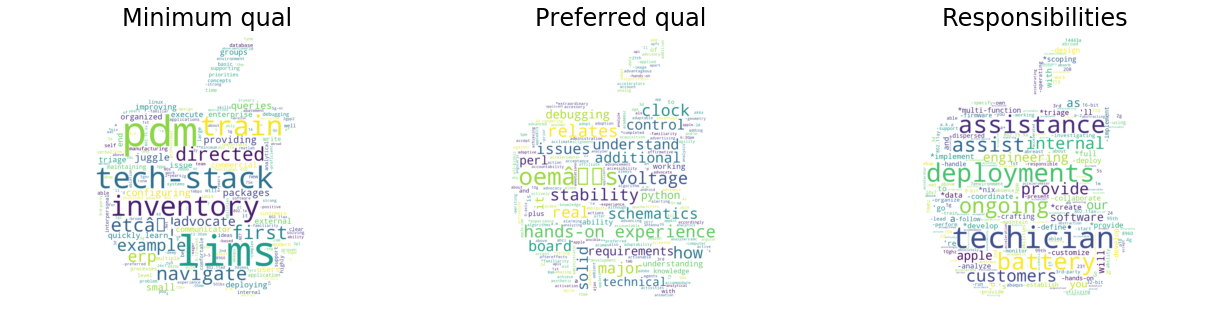

In [24]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
G = np.array(Image.open('wordcloud_masks/apple-icon.png'))

plt.figure(figsize=(21, 5))

plt.subplot(131)
tfidf_dict = min_qual_tfidfm.to_dict(orient='records')
wordcloud = WordCloud(mask=G,background_color="white").fit_words(tfidf_dict[0])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Minimum qual',size=24)

plt.subplot(132)
tfidf_dict = pref_qual_tfidfm.to_dict(orient='records')
wordcloud = WordCloud(mask=G,background_color="white").fit_words(tfidf_dict[0])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Preferred qual',size=24)

plt.subplot(133)
tfidf_dict = resp_tfidfm.to_dict(orient='records')
wordcloud = WordCloud(mask=G,background_color="white").fit_words(tfidf_dict[0])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Responsibilities',size=24)

plt.savefig('out_graphs/apple_wordcloud.png', format='png')
plt.show()

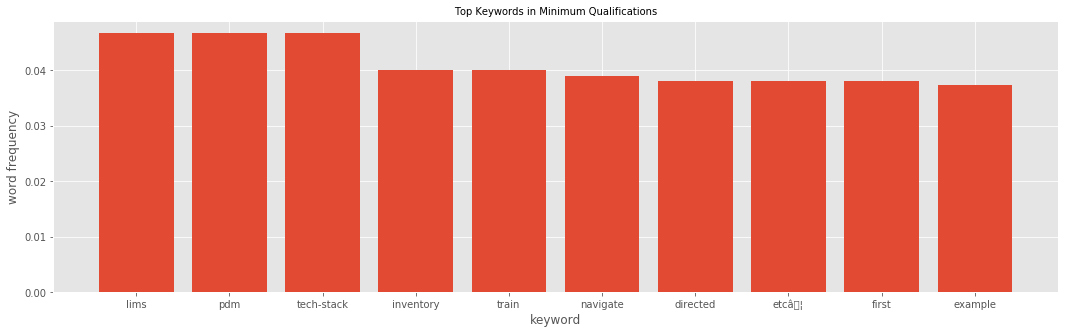

In [25]:
font_path = r'/usr/share/fonts/dejavu/DejaVuSans.ttf'

plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 1, 1)
plt.xlabel('keyword')
plt.ylabel('word frequency')
title = 'Top Keywords in Minimum Qualifications'
plot_tfidf_bar(min_qual_tfidfm, text_index=0, ax=ax1, font_path=font_path, bin=10, title=title)

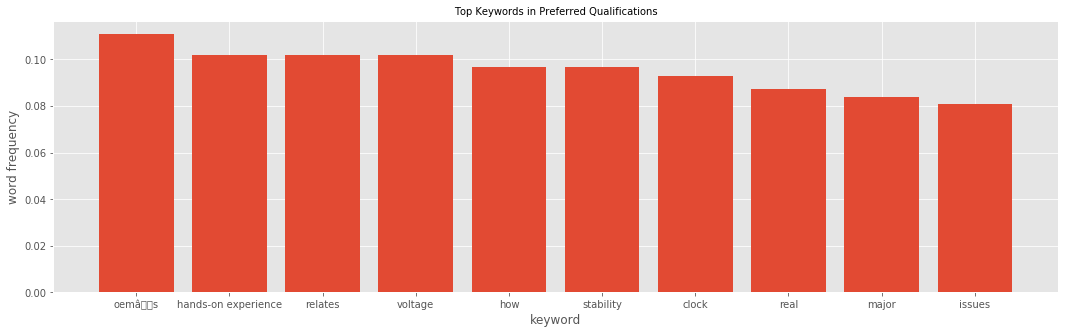

In [26]:
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 1, 1)
plt.xlabel('keyword')
plt.ylabel('word frequency')
title = 'Top Keywords in Preferred Qualifications'
plot_tfidf_bar(pref_qual_tfidfm, text_index=0, ax=ax1, font_path=font_path, bin=10, title=title)

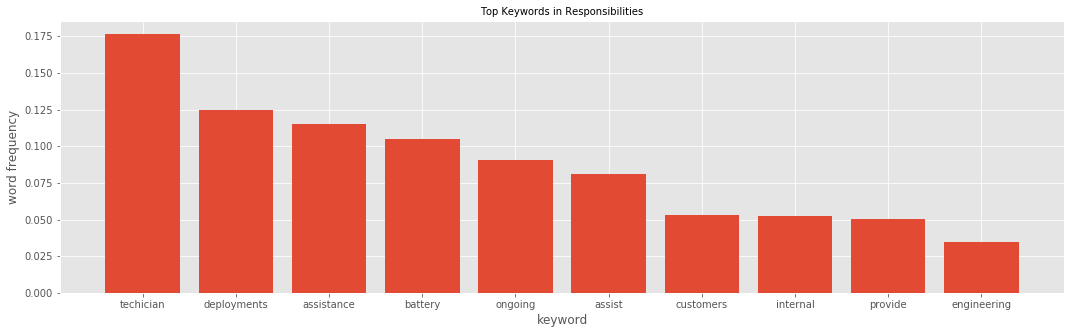

In [27]:
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 1, 1)
plt.xlabel('keyword')
plt.ylabel('word frequency')
title = 'Top Keywords in Responsibilities'
plot_tfidf_bar(resp_tfidfm, text_index=0, ax=ax1, font_path=font_path, bin=10, title=title)

### 6. Relation between keywords in Qualifications and Responsibilities Text

In [28]:
keyword_df = df.copy()

# Replace NaN columns with empty strings.
keyword_df = keyword_df.replace(np.nan, '', regex=True)

# Split job titles by comma into separate columns.
keyword_df['title'] = keyword_df['title'].str.split(' - ', expand=True)[0]

# Combine minimum_qual, preferred_qual and responsibilities into a single column.
keyword_df['text'] = list(keyword_df['minimum_qual'] + keyword_df['preferred_qual'] + keyword_df['responsibilities'])

# Drop unused columns.
keyword_df = keyword_df.drop(['location', 'minimum_qual', 'preferred_qual', 'responsibilities'], axis=1)
keyword_df.head(5)

,title,education&experience,text
0,Software Technician,"AS/BS in Information Technology, or equivalent",2-5 years experience supporting or deploying a...
1,Software Engineer,EDUCATION\nBS or MS in Computer Engineering or...,KEY QUALIFICATIONS\nA genuine passion for fixi...
2,Software Engineer,"BS, MS or PhD, in Computer Science, or equival...",- 3+ years experience working on large scale d...
3,Software Engineer,"BS, MS or PhD, in Computer Science, or equival...",- 3+ years experience working on large scale d...
4,Software Engineer,"M.S. or PhD in Computer Science, Electrical En...",Demonstrated experience integrating full-syste...


In [29]:
from collections import Counter

def get_keywords(tokens, num, stopwords=[]):
    if len(stopwords) > 0:
        for stopword in stopwords:
            for token in tokens:
                if token == stopword:
                    tokens.remove(token)
    return [t[0] for t in Counter(tokens).most_common(num)]

In [30]:
stopwords = []
with open('stopwords.txt', 'r') as f:
    for line in f:
        if not line.startswith('#'):
            stopwords.append(line.strip())
            
#tokens = tokenize(tokenizer, s, lowercase=True, preserve_case_words=['Go'])
#get_keywords(tokens, 3, stopwords)

In [31]:
# Clean up the text.
tokenizer = nltk.tokenize.MWETokenizer(separator=' ')
import_terms(tokenizer, 'cs_terms.txt')
keyword_df['text'] = keyword_df['text'].apply(lambda s: ' '.join(tokenize(tokenizer, s, lowercase=True, preserve_case_words=['Go', '.NET'])))
keyword_df

# Create keyword columns.
keyword_df['keyword'] = list(','.join(get_keywords(tokenize(tokenizer, col, lowercase=True, preserve_case_words=['Go']), 3, stopwords)) for col in keyword_df['text'])
keyword_df.head(10)

,title,education&experience,text,keyword
0,Software Technician,"AS/BS in Information Technology, or equivalent",years experience supporting or deploying appli...,"software,ability,application"
1,Software Engineer,EDUCATION\nBS or MS in Computer Engineering or...,key qualifications a genuine passion for fixin...,"issues,hardware,understanding"
2,Software Engineer,"BS, MS or PhD, in Computer Science, or equival...",years experience working on large scale distri...,"distributed systems,large,control"
3,Software Engineer,"BS, MS or PhD, in Computer Science, or equival...",years experience working on large scale distri...,"distributed systems,large,control"
4,Software Engineer,"M.S. or PhD in Computer Science, Electrical En...",demonstrated experience integrating full-syste...,"performance,strong,team"
5,Software Engineer,BS or MS in Computer Science or equivalent wor...,a successful track-record and proven experienc...,"services,backend,internet"
6,Software Engineer,A BS/MS/PhD in Electrical or Computer Engineer...,passion to create amazing products which users...,"passion,excellent,apple"
7,Software Engineer,Bachelorâs Degree or Equivalent with 2+ year...,in-depth understanding of data structures and ...,"development,data,understanding"
8,Software Engineer,A BS/MS/PhD in Electrical or Computer Engineer...,passion to create amazing products which users...,"passion,excellent,apple"
9,Software Engineer,BS/MS in CS/CE (or equivalent),years experience developing system software su...,"software,skills,drivers"


In [32]:
keywords_array=[]
for index, row in keyword_df.iterrows():
    keywords = row['keyword'].split(',')
    for kw in keywords:
        keywords_array.append((kw.strip(' '), row['keyword']))
kw_df = pd.DataFrame(keywords_array).rename(columns={0:'keyword', 1:'keywords'})

In [33]:
kw_df.head(10)

,keyword,keywords
0,software,"software,ability,application"
1,ability,"software,ability,application"
2,application,"software,ability,application"
3,issues,"issues,hardware,understanding"
4,hardware,"issues,hardware,understanding"
5,understanding,"issues,hardware,understanding"
6,distributed systems,"distributed systems,large,control"
7,large,"distributed systems,large,control"
8,control,"distributed systems,large,control"
9,distributed systems,"distributed systems,large,control"


In [34]:
document = kw_df.keywords.tolist()
names = kw_df.keyword.tolist()

document_array = []
for item in document:
    items = item.split(',')
    document_array.append((items))

occurrences = OrderedDict((name, OrderedDict((name, 0) for name in names)) for name in names)

# Find the co-occurrences:
for l in document_array:
    for i in range(len(l)):
        for item in l[:i] + l[i + 1:]:
            occurrences[l[i]][item] += 1

co_occur = pd.DataFrame.from_dict(occurrences )

In [35]:
document = kw_df.keywords.tolist()
names = kw_df.keyword.tolist()

document_array = []
for item in document:
    items = item.split(',')
    document_array.append((items))

occurrences = OrderedDict((name, OrderedDict((name, 0) for name in names)) for name in names)

# Find the co-occurrences:
for l in document_array:
    for i in range(len(l)):
        for item in l[:i] + l[i + 1:]:
            occurrences[l[i]][item] += 1

co_occur = pd.DataFrame.from_dict(occurrences)

In [36]:
co_occur.head(10)

,software,ability,application,issues,hardware,understanding,distributed systems,large,control,performance,...,partner,merchandising,safety,electromagnetic,cell,interactive,construction,archiving,ais,youâre
'll,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
're,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
've,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-familiar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-proficient,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5gnr,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Go,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abaqus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ability,15,0,6,9,18,18,0,9,0,3,...,0,0,0,0,0,0,0,0,0,0


In [37]:
co_occur.to_csv('keyword_co_occur_apple.csv')

![](https://i.imgur.com/gJ09t0K.png)

In [43]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='myapplication')
dic={}
key=[]
lat=[]
lon=[]
for lo in df['location']:
    if lo in dic:
        continue
    try:
        location = geolocator.geocode(lo)
        dic[lo]=(location.latitude,location.longitude)
        key.append(lo)
        lat.append(location.latitude)
        lon.append(location.longitude)
        print(dic[lo])
    except:
        try:
            location = geolocator.geocode(lo)
            dic[lo]=(location.latitude,location.longitude)
            key.append(lo)
            lat.append(location.latitude)
            lon.append(location.longitude)
            print(dic[lo])
        except:
            print('error')       
print(len(dic))
    #try:
        #location = geolocator.geocode(lo)
        #arr.append((location.lat,location.lon))
    #except:
        #print("ERROR")
        #arr.append(('none','none'))

(37.3541132, -121.9551744)
(30.2711286, -97.7436995)
(17.3616079, 78.4746286)
(32.7762719, -96.7968559)
(47.3769434, 8.5414061)
(32.1656255, 34.8469023)
(1.3408528, 103.878446863736)
(49.9954522, 14.628005)
(47.6038321, -122.3300624)
(-8.0641931, -34.8781517)
(39.906217, 116.3912757)
(39.7392364, -104.9848623)
(12.9791198, 77.5912997)
(28.5421097, -81.3790388)
(37.7792808, -122.4192363)
(22.5445697, 114.0545346)
(32.8191218, 34.9983856)
(31.2253441, 121.4888922)
(51.8979282, -8.4705806)
(-20.8817051, 55.4497432)
(51.5073219, -0.1276474)
(48.1371079, 11.5753822)
(35.7803977, -78.6390989)
(52.2034823, 0.1235817)
(45.421106, -75.690308)
(51.7492956, -0.3422526)
(59.3251172, 18.0710935)
(32.7174209, -117.1627714)
(52.3745403, 4.89797550561798)
(38.5815719, -121.4943996)
(49.2608724, -123.1139529)
(40.4416941, -79.9900861)
(37.3228934, -122.0322895)
(55.6867243, 12.5700724)
(35.6828387, 139.7594549)
(34.0211224, -118.3964665)
(45.5202471, -122.6741949)
(51.2254018, 6.7763137)
(-36.8534665, 

In [44]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='myapplication')
location = geolocator.geocode("Chicago Illinois")
print(location.latitude)

41.8755616


In [46]:
import pandas as pd # Reading csv file 
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
import geopandas as gpd # To create GeodataFrame
geometry = [Point(xy) for xy in zip(lon, lat)]
# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}
# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(key, crs=crs, geometry=geometry)
gdf.head(10)
#cities.plot(ax=base, marker='o', color='red', markersize=5)

,0,geometry
0,"Santa Clara Valley (Cupertino), California, Un...",POINT (-121.9551744 37.3541132)
1,"Austin, Texas, United States",POINT (-97.74369950000001 30.2711286)
2,"Hyderabad, Telangana, India",POINT (78.4746286 17.3616079)
3,"Dallas, Texas, United States",POINT (-96.7968559 32.7762719)
4,"Zurich, Zurich, Switzerland",POINT (8.5414061 47.3769434)
5,"Herzliya, Israel",POINT (34.8469023 32.1656255)
6,"Singapore, Singapore, Singapore",POINT (103.878446863736 1.3408528)
7,"Prague, Bohemia, Czechia",POINT (14.628005 49.9954522)
8,"Seattle, Washington, United States",POINT (-122.3300624 47.6038321)
9,"Recife, Pernambuco, Brazil",POINT (-34.8781517 -8.064193100000001)


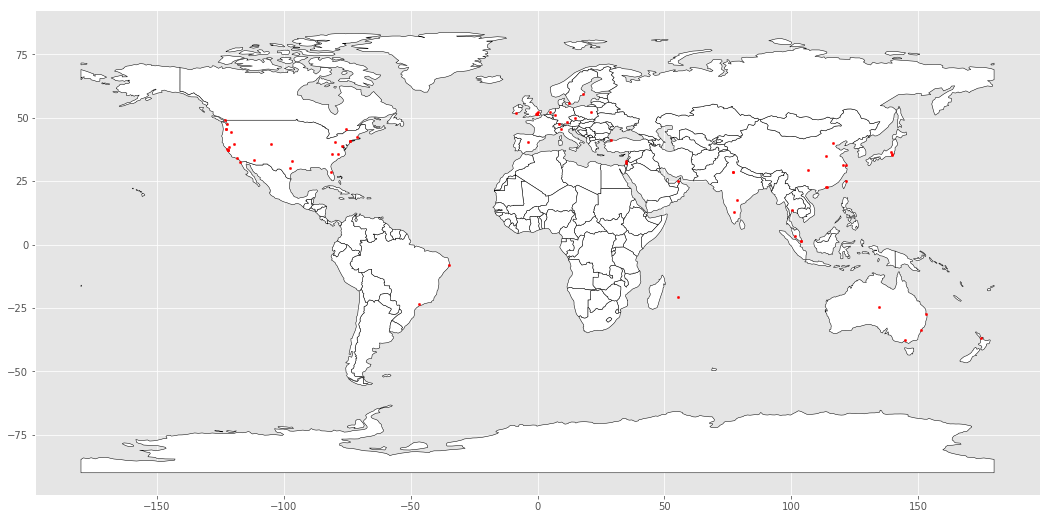

In [47]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black',figsize=(18,16))
gdf.plot(ax=base, marker='o', color='red', markersize=5)